Dataset columns: ['Age', 'Sex', 'Hypertension', 'Heart_Disease', 'Work_Type', 'Residence_Type', 'Average_Glucose_Level', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Alcohol_Intake', 'Stress_Level', 'Blood_Pressure', 'Cholesterol', 'Family_History', 'MRI_Result', 'Stroke']
Dataset shape: (41000, 17)

First few rows:
   Age  Sex  Hypertension  Heart_Disease  Work_Type  Residence_Type  \
0   69    1             0              0          2               1   
1   32    1             0              1          1               1   
2   89    0             0              0          2               1   
3   78    0             0              0          2               0   
4   38    0             0              0          0               1   

   Average_Glucose_Level    BMI  Smoking_Status  Physical_Activity  \
0                 153.40  17.93               0                 38   
1                 158.33  40.75               0                101   
2                  73.54  16.81            

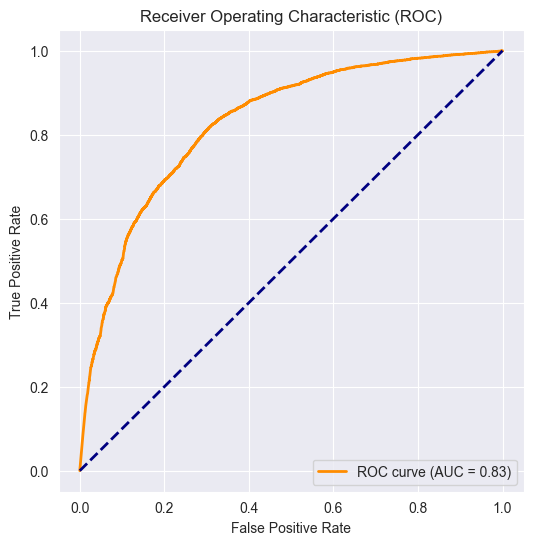

<Figure size 600x600 with 0 Axes>

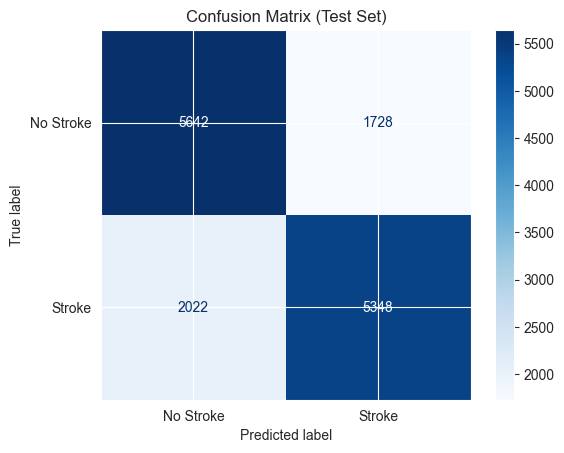


--- Saving Model ---
Model saved successfully!
Expected 16 features in order: ['Age', 'Sex', 'Hypertension', 'Heart_Disease', 'Work_Type', 'Residence_Type', 'Average_Glucose_Level', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Alcohol_Intake', 'Stress_Level', 'Blood_Pressure', 'Cholesterol', 'Family_History', 'MRI_Result']


In [4]:
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc


# Load the preprocessed dataset
df = pd.read_csv(r"D:\Stroke_prediction_project\preprocessed_stroke_data.csv")

# Check the columns
print("Dataset columns:", df.columns.tolist())
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Verify data types (should be numeric)
print("\nData types:")
print(df.dtypes)

# Check for any non-numeric columns that need encoding
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"\nWarning: Found non-numeric columns: {non_numeric_cols}")
    print("These need to be encoded before training!")
    # If there are still string columns, encode them
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for col in non_numeric_cols:
        df[col] = le.fit_transform(df[col])

# Separate features and target
X = df.drop('Stroke', axis=1)
y = df['Stroke']

print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Get feature names for later use
feature_names = X.columns.tolist()
print(f"\nFeature names ({len(feature_names)}): {feature_names}")

# Apply SMOTE to balance the dataset
print("\n--- Applying SMOTE ---")
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"After SMOTE:\n{pd.Series(y_resampled).value_counts()}")

# Train-test split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier
print("\n--- Training Random Forest ---")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

# Train on scaled data
model.fit(X_train_scaled, y_train)

# Evaluate the model
print("\n--- Model Evaluation ---")
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f"Training Accuracy: {model.score(X_train_scaled, y_train):.4f}")
print(f"Test Accuracy: {model.score(X_test_scaled, y_test):.4f}")

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred_test, target_names=['No Stroke', 'Stroke']))

print("\n--- Confusion Matrix (Test Set) ---")
cm = confusion_matrix(y_test, y_pred_test)
print("True Negatives:", cm[0,0])
print("False Positives:", cm[0,1])
print("False Negatives:", cm[1,0])
print("True Positives:", cm[1,1])

print("\n--- Top 10 Most Important Features ---")
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.head(10))

print("\n--- Testing with High-Risk Patient ---")
# This should be a high-risk profile based on your dataset
high_risk_patient = pd.DataFrame([[
    70,    # Age (older)
    1,     # Sex (1=Male)
    1,     # Hypertension (Yes)
    1,     # Heart_Disease (Yes)
    1,     # Work_Type (encoded value)
    1,     # Residence_Type (encoded)
    250.0, # Average_Glucose_Level (high)
    35.0,  # BMI (high)
    2,     # Smoking_Status (Currently=2)
    2.0,   # Physical_Activity (low)
    10,    # Alcohol_Intake (high)
    9,     # Stress_Level (high)
    180,   # Blood_Pressure (high)
    280,   # Cholesterol (high)
    1,     # Family_History (Yes)
    85.0   # MRI_Result (if this column exists, high value)
]], columns=feature_names)

# Scale the test patient
high_risk_scaled = scaler.transform(high_risk_patient)

# Predict
prediction = model.predict(high_risk_scaled)[0]
probabilities = model.predict_proba(high_risk_scaled)[0]

print(f"Prediction: {'STROKE RISK' if prediction == 1 else 'NO STROKE RISK'}")
print(f"Probability of No Stroke: {probabilities[0]:.2%}")
print(f"Probability of Stroke: {probabilities[1]:.2%}")

from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.show()


print("\n--- Saving Model ---")
model_package = {
    'model': model,
    'scaler': scaler,
    'feature_names': feature_names,
    'version': '2.0',
    'training_accuracy': model.score(X_train_scaled, y_train),
    'test_accuracy': model.score(X_test_scaled, y_test)
}


with open(r"D:\Stroke_prediction_project\models\random_forest_fixed.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("Model saved successfully!")
print(f"Expected {len(feature_names)} features in order: {feature_names}")